In [22]:
import numpy as np
import pandas as pd
import pickle
import time

from sklearn.model_selection import train_test_split

from text_models import TextClassifier, extract_text_blocks, tokenize_data, load_glove_embedding
from lstm_attention_model import AttentionLSTM, train_part, evaluate, predict_labels
from helper import Dataset
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

import sys

def progress_bar(i, total):
    line_end = ""
    if i == total:
        line_end = "\n"
        
    size = 40
    x = int(round(size*i/total))
    text = '\rStatus: [%s] %d/%d %s' % ("#"*x + "."*(size-x), i, total, line_end)
    sys.stdout.write(text)
    sys.stdout.flush()

# Load Dataset 

The dataset is a pandas dataframe with two columns: Text labels and the text sentences and sub-sentences. There are 8 different categories(labels) in total. Each sentence could also have multiple categories(labels) associated with it.

In [5]:
df = pickle.load( open( "review_labelled.pkl", "rb" ))

In [6]:
df.tail

<bound method NDFrame.tail of                                                    label  \
16                            [Job Security/Advancement]   
149    [Job Security/Advancement, business_vision_com...   
220                           [Job Security/Advancement]   
233                           [Job Security/Advancement]   
396                           [Job Security/Advancement]   
...                                                  ...   
48187                           [wlb_working_conditions]   
48198                           [wlb_working_conditions]   
48201                           [wlb_working_conditions]   
48218                           [wlb_working_conditions]   
48290                           [wlb_working_conditions]   

                                   pp_sent  
16                  developing your skills  
149                        rapidly growing  
220      easy to get your foot in the door  
233            opportunity for advancement  
396                  car

# Train LSTM

Train a Multilabel text classifier using LSTM. This model has the following architecture: <br>
Input -> Word Embedding Layer -> LSTM -> Spatial Dropout -> Fully Connected -> RELU -> Fully Connected -> Sigmoid <br>
Here the LSTM output to the next fully connected layer is from the last time step only. All the model implementations could be found at text_models.py

In [ ]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])
model_lstm = TextClassifier(tokenizer, label_index)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

history_lstm = model_lstm.train(X_train, y_train, 'LSTM')
model_lstm.model.summary()

Evaluate Model

In [ ]:
test_loss, test_acc = model_lstm.evaluate(X_test,y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [ ]:
plot_graphs(history_lstm, 'binary_accuracy')

In [ ]:
plot_graphs(history_lstm, 'loss')

# Train CNN

Model Architecture: <br> Input -> Word Embedding Layer -> Convolution Layer -> RELU -> Global Max Pool -> Fully Connected -> Sigmoid 

In [18]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])
model_cnn = TextClassifier(tokenizer, label_index)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

history_cnn = model_cnn.train(X_train, y_train, 'CNN')
model_cnn.model.summary()

Shape of data tensor: (8000,)
Found 3796 unique tokens.
Train on 4824 samples, validate on 536 samples
Epoch 1/5
4824/4824 [==============================] - 2s 450us/sample - loss: 0.4380 - binary_accuracy: 0.8612 - val_loss: 0.3451 - val_binary_accuracy: 0.8773
Epoch 2/5
4824/4824 [==============================] - 2s 400us/sample - loss: 0.2402 - binary_accuracy: 0.9058 - val_loss: 0.1247 - val_binary_accuracy: 0.9580
Epoch 3/5
4824/4824 [==============================] - 2s 420us/sample - loss: 0.0723 - binary_accuracy: 0.9790 - val_loss: 0.0510 - val_binary_accuracy: 0.9851
Epoch 4/5
4824/4824 [==============================] - 2s 414us/sample - loss: 0.0310 - binary_accuracy: 0.9914 - val_loss: 0.0330 - val_binary_accuracy: 0.9886
Epoch 5/5
4824/4824 [==============================] - 2s 398us/sample - loss: 0.0170 - binary_accuracy: 0.9957 - val_loss: 0.0259 - val_binary_accuracy: 0.9911
Model: "sequential"
_________________________________________________________________
Layer 

Evaluate CNN Model

In [19]:
test_loss, test_acc = model_cnn.evaluate(X_test,y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

2640/2640 [==============================] - 0s 80us/sample - loss: 0.0287 - binary_accuracy: 0.9907
Test Loss: 0.028670915351672606
Test Accuracy: 0.9907196760177612


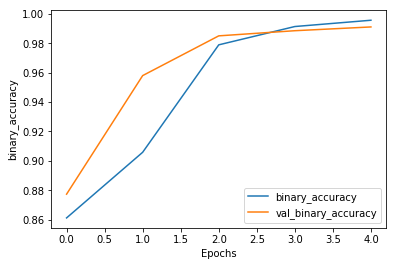

In [26]:
plot_graphs(history_cnn, 'binary_accuracy')

In [ ]:
plot_graphs(history_cnn, 'loss')

# Train CNN Glove

Model Architecture: 
Input -> GLoVe Word Embedding(Non trainable)  -> Convolution Layer -> RELU -> Global Max Pool -> Fully Connected -> Sigmoid

In [ ]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])
model_cnn_glove = TextClassifier(tokenizer, label_index)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

history_cnn_glove = model_cnn_glove.train(X_train, y_train, 'CNN_Glove')
model_cnn_glove.model.summary()

Evaluate Glove Model

In [ ]:
test_loss, test_acc = model_cnn_glove.evaluate(X_test,y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [ ]:
plot_graphs(history_cnn_glove, 'binary_accuracy')

In [ ]:
plot_graphs(history_cnn_glove, 'loss')

# Train MLP

Model Architecture: <br>
Input -> Word Embedding Layer -> 4x(Fully Connected -> RELU) -> Fully Connected -> Sigmoid <br>

In [ ]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])
model_mlp = TextClassifier(tokenizer, label_index)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

history_mlp = model_mlp.train(X_train, y_train, 'MLP')
model_mlp.model.summary()

Evaluate MLP Model

In [ ]:
test_loss, test_acc = model_mlp.evaluate(X_test,y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [ ]:
plot_graphs(history_mlp, 'binary_accuracy')

In [ ]:
plot_graphs(history_mlp, 'loss')

The cross_validation function iterates over different hyper parameter settings to find the best model configuration.

In [ ]:
def cross_validation(model_type, X_train, y_train, tokenizer, label_index):

    learning_rates = np.linspace(1e-3, 5e-4, 5)
    regularization_strengths = np.linspace(0.001, 1.5, 5)

    best_val = -1.
    best_train = -1
    best_model = None
    best_lr = None
    best_reg = None
    progress_counter = 0
    total_tests = learning_rates.shape[0] * regularization_strengths.shape[0]

    print('Cross validation : ', model_type)
    
    start_time = time.time()
    
    for lr in learning_rates:
        for reg in regularization_strengths:
            # Train the network
            model = TextClassifier(tokenizer, label_index, verbose=0)
            history = model.train(X_train, y_train, model_type, learning_rate=lr, regularization=reg)
            val_acc_history = history.history['val_accuracy']
            val_acc = val_acc_history[-1]

            if val_acc > best_val:
                del best_model
                best_val = val_acc
                best_model = model
                best_lr = lr
                best_reg = reg
            else:
                del model
                
            progress_counter += 1    
            progress_bar(progress_counter, total_tests)
            
    best_hist = best_model.history.history
    
    train_acc, val_loss, train_loss = best_hist['accuracy'][-1], best_hist['val_loss'][-1], best_hist['loss'][-1]

    print("Execution time: %s seconds" % (time.time() - start_time))
    print('Best validation accuracy: %f - Train accuracy: %f - val loss: %f - train loss: %f'
          % (best_val, train_acc, val_loss, train_loss) )
    print('Best learning rate: %f - regularization : %f' % (best_lr, best_reg) )
    return best_model

In [ ]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

best_lstm = cross_validation("LSTM", X_train, y_train, tokenizer, label_index)
best_mlp = cross_validation("MLP", X_train, y_train, tokenizer, label_index)
best_cnn = cross_validation("CNN", X_train, y_train, tokenizer, label_index)
best_glove = cross_validation("CNN_Glove", X_train, y_train, tokenizer, label_index)

CNN seems to perform the best amongst all the other models here.
<br> 
CNN with GLoVe embedding is also slightly slower than CNN(with learnt embedding) while not performing any better.<br>
LSTM was approximately 7 times slower than CNN and also didn't perform any better than CNN. 
<br>
MLP was expected to perform the worst as by design it has no temporal information. 
<br><br>
Evaluating Test Accuracies on the best models after cross validation and hyper parameter tuning. 

In [ ]:
test_loss, test_acc = best_cnn.evaluate(X_test,y_test)
print('CNN: Test Loss: {}'.format(test_loss))
print('CNN: Test Accuracy: {}'.format(test_acc))

test_loss, test_acc = best_glove.evaluate(X_test,y_test)
print('CNN Glove: Test Loss: {}'.format(test_loss))
print('CNN Glove: Test Accuracy: {}'.format(test_acc))

test_loss, test_acc = best_lstm.evaluate(X_test,y_test)
print('LSTM: Test Loss: {}'.format(test_loss))
print('LSTM: Test Accuracy: {}'.format(test_acc))

test_loss, test_acc = best_mlp.evaluate(X_test,y_test)
print('MLP: Test Loss: {}'.format(test_loss))
print('MLP: Test Accuracy: {}'.format(test_acc))

The below code block loads a review, splits it into sentences and sub-sentences, and returns a flattened list

In [9]:
data_pros_cons = pickle.load( open( "review_pros_cons.pkl", "rb" ))
review = data_pros_cons.iloc[10,0]
blocks = extract_text_blocks(review)

Text example

In [10]:
print(review)

I worked for the internal marketing team (MarCom) on the creative side. The best thing about working at Apple is your coworkers. They do an excellent job of hiring incredibly intelligent, talented people. It's quite humbling to work alongside such accomplished people. You'll always feel like the dumbest person in the room, which is great because everyone has so much to teach you. Most of them are ego-free (about 70% of them) and will help you whenever possible. There are so many personality types, though nearly all of them are perfectionist Type A people. If that is your kind of crew, you'll do well.

The work usually comes in waves. When you're on, you're all the way on. For weeks at a time you can expect late nights and no weekends. On the flip side, when it's slow, it's very slow. You can often work from home or take comp days. During downtimes it is not uncommon to go in for five hours including a long lunch and then go home.

In addition to this, the compensation is good. The stoc

In [11]:
# Helper function to print sentences and categories from the prediction list
def print_categories_sentences(prediction_dict):
    
    if len(prediction_dict) == 0:
        print ("No predictions made")
        
    for k,v in predictions.items():
        categories = [i[1] for i in v[0]]
        sentence = v[1]
        print(categories, sentence)

# Predict

The predict function takes in a list of important text blocks as input, and returns a list of "useful/important" sentences with their categories and confidence values. <br>
Below we visualize the outputs of the 4 models on the text above(review).

# CNN

In [23]:
predictions = best_cnn.predict(blocks)
print_categories_sentences(predictions)

['Job Security/Advancement'] I worked for the internal marketing team (MarCom) on the creative side.
['culture_team'] They do an excellent job of hiring incredibly intelligent, talented people.
['salary_benefits'] Most of them are ego-free (about 70% of them) and will help you whenever possible.
['salary_benefits'] When you're on, you're all the way on.
['wlb_working_conditions'] For weeks at a time you can expect late nights and no weekends.
['culture_team'] On the flip side, when it's slow, it's very slow.
['wlb_working_conditions'] You can often work from home or take comp days.
['wlb_working_conditions'] During downtimes it is not uncommon to go in for five hours including a long lunch and then go home.
['salary_benefits'] In addition to this, the compensation is good.
['salary_benefits'] The stock program is okay.
['culture_team'] Finally, Tim Cook seems like a genuinely good person.


# CNN Glove

In [ ]:
predictions = best_glove.predict(blocks)
print_categories_sentences(predictions)

# LSTM

In [ ]:
predictions = best_lstm.predict(blocks)
print_categories_sentences(predictions)

# MLP

In [ ]:
predictions = best_mlp.predict(blocks)
print_categories_sentences(predictions)

# LSTM with Attention

In [12]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

Shape of data tensor: (8000,)
Found 3796 unique tokens.


In [13]:
train_dset = Dataset(X_train, y_train, batch_size=64, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=True)
test_dset = Dataset(X_test, y_test, batch_size=64)

In [14]:
sequence_length = 100
embedding_dim = 50
model = AttentionLSTM(sequence_length, embedding_dim)

train_part(model, train_dset, val_dset, num_epochs=5, is_training=True)

Iteration 0, Epoch 1, Loss: 0.690375566482544, Accuracy: 53.515625, Val Loss: 0.6813831329345703, Val Accuracy: 77.8359375
Iteration 100, Epoch 2, Loss: 0.40696054697036743, Accuracy: 86.80137634277344, Val Loss: 0.3904970586299896, Val Accuracy: 86.8203125
Iteration 200, Epoch 3, Loss: 0.39767274260520935, Accuracy: 86.80683135986328, Val Loss: 0.36877337098121643, Val Accuracy: 86.8203125
Iteration 300, Epoch 5, Loss: 0.20571783185005188, Accuracy: 92.7734375, Val Loss: 0.18757209181785583, Val Accuracy: 93.3671875


In [15]:
pred = evaluate( model, test_dset)

Test set accuracy: 96.094%


In [16]:
predictions = predict_labels(blocks, model, tokenizer, label_index)

In [17]:
print_categories_sentences(predictions)

['Job Security/Advancement'] I worked for the internal marketing team (MarCom) on the creative side.
['culture_team'] They do an excellent job of hiring incredibly intelligent, talented people.
['management'] It's quite humbling to work alongside such accomplished people.
['management'] There are so many personality types, though nearly all of them are perfectionist Type A people.
['haras_discrim_sexism'] If that is your kind of crew, you'll do well.
['management'] The work usually comes in waves.
['management'] When you're on, you're all the way on.
['management'] In addition to this, the compensation is good.
['management'] But the pay is more than fair and their annual reviews pretty much guarantee a raise, bonus, and/or more stock.
['management'] Even in the relatively short time he's been in his role, he has made enormous leaps to give that company a real set of values that are current with this generation.
